In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn 
import librosa
import librosa.display as display
import os

from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise
from kapre.time_frequency import Spectrogram

%matplotlib inline

#!rm -r train_data
#!rm -r val_data
#!rm -r models
#!mkdir models

# suppress warnings
warnings.filterwarnings("ignore")

SOUND_DIR = "/project/data/birdsong-recognition/train_audio/"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

Using TensorFlow backend.


In [2]:
# function for creating Mel Spectrogram
def createMelSpectrogram(input_path, fileName, output_path, saveOrShow=0):
    
    # load sound signal
    signal, sr = librosa.load(os.path.join(input_path, fileName), duration=10)
    
    # create Mel Spectrogram
    S = Melspectrogram(n_dft=1024, 
                       n_hop=256,
                       input_shape=(1, signal.shape[0]),
                       padding='same', sr=sr, n_mels=224, fmin=1400, fmax=sr/2,
                       power_melgram=2.0, return_decibel_melgram=True,
                       trainable_fb=False, trainable_kernel=False)(signal.reshape(1, 1, -1)).numpy()
    
    S = S.reshape(S.shape[1], S.shape[2])
    
    if saveOrShow == 0:   
        matplotlib.image.imsave(os.path.join(output_path, fileName.split(".")[0] + ".png"), S)
    else:
        #plt.imshow(S)
        #plt.show()
        display.specshow(S, sr=sr)
        plt.show()

## Visualizing Mel-Spectrogram of an audio

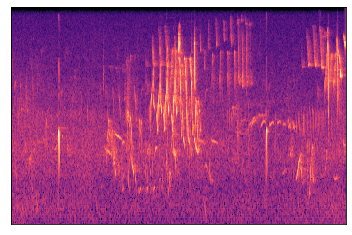

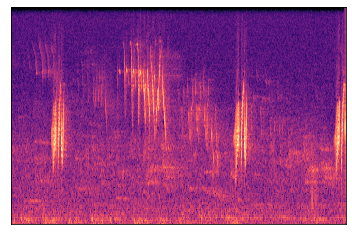

In [3]:
# bird: aldfly
createMelSpectrogram(SOUND_DIR+"aldfly", "XC134874.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"aldfly", "XC16967.mp3", "", 1)

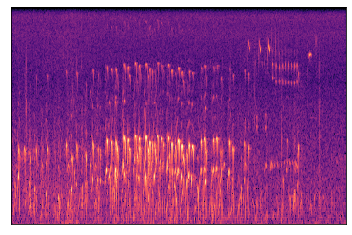

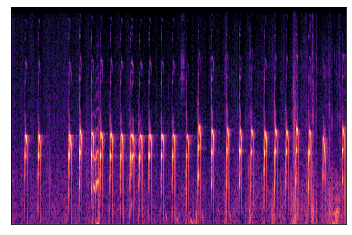

In [4]:
# bird: ameavo
createMelSpectrogram(SOUND_DIR+"ameavo", "XC133080.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"ameavo", "XC139829.mp3", "", 1)

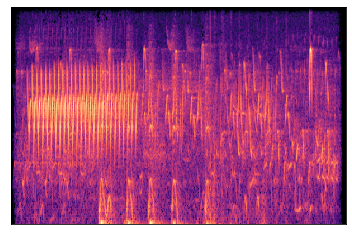

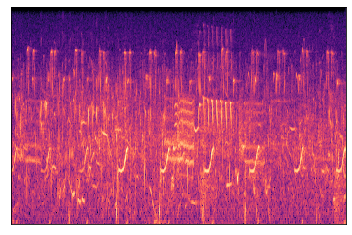

In [5]:
# amebit
createMelSpectrogram(SOUND_DIR+"amebit", "XC141316.mp3", "", 1)
createMelSpectrogram(SOUND_DIR+"amebit", "XC184876.mp3", "", 1)

## Create Mel-Spectrogram for training

In [6]:
# select top 20 birds for training
BIRDS = os.listdir("data/birdsong-recognition/train_audio/")[0:20]

In [7]:
# list of birds
#BIRDS = ["aldfly", "ameavo", "amebit", "amecro", "amegfi",
#         "amekes", "amepip", "amered", "amerob", "amewig"]

train_folder = "train_data_decibel_20/"
val_folder = "val_data_decibel_20/"

if not os.path.exists(train_folder): os.mkdir(train_folder)
if not os.path.exists(val_folder): os.mkdir(val_folder)

In [8]:
### This takes long time to run ###

# create train and val spectrogram
np.random.seed(1234)
for bird in tqdm(BIRDS):
    INPUT_DIR = os.path.join("data/birdsong-recognition/train_audio/", bird)
    TRAIN_DIR = os.path.join(train_folder, bird)
    VAL_DIR = os.path.join(val_folder, bird)
    
    # create folders
    if not(os.path.exists(TRAIN_DIR)) and not(os.path.exists(VAL_DIR)): 
        
        os.mkdir(TRAIN_DIR)
        os.mkdir(VAL_DIR)

        # split into train and val set
        for f in os.listdir(INPUT_DIR):
            rand = np.random.randint(0, 10)
            if f[0] != ".":
                if rand <= 7: 
                    createMelSpectrogram(INPUT_DIR, f, TRAIN_DIR)
                else:
                    createMelSpectrogram(INPUT_DIR, f, VAL_DIR)        

100%|██████████| 20/20 [00:00<00:00, 52298.05it/s]


In [9]:
IM_SIZE = (224,224,3)
BATCH_SIZE = 8

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=None,
                                   rescale=1/255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(train_folder,
                                                  classes=BIRDS, 
                                                  target_size=IM_SIZE[0:2], 
                                                  class_mode='categorical', 
                                                  shuffle=True, batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(preprocessing_function=None, rescale=1/255)

val_batches = train_datagen.flow_from_directory(val_folder,
                                                  classes=BIRDS, 
                                                  target_size=IM_SIZE[0:2], 
                                                  class_mode='categorical', 
                                                  shuffle=False, batch_size=1)

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_batches.classes), 
                                                  train_batches.classes)

Found 1460 images belonging to 20 classes.
Found 364 images belonging to 20 classes.


In [11]:
net = efn.EfficientNetB3(include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE)
#net.trainable = False

x = net.output

#x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
#x2 = tf.keras.layers.GlobalMaxPool2D()(x)
#x = tf.keras.layers.Concatenate(axis=1)([x1, x2])

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output_layer = tf.keras.layers.Dense(len(BIRDS), activation='softmax', name='softmax')(x)
net_final = tf.keras.Model(inputs=net.input, outputs=output_layer)

net_final.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
#net_final.summary()

In [13]:
ModelCheck = tf.keras.callbacks.ModelCheckpoint('models/efficientnet_checkpoint.h5', monitor='val_loss', verbose=0, 
                             save_best_only=True, save_weights_only=True, mode='auto')

net_final.reset_states()
net_final.fit_generator(train_batches, 
                        validation_data=val_batches,
                        steps_per_epoch = int(len(train_batches.classes)/BATCH_SIZE)+1,
                        validation_steps=len(val_batches.classes),
                        epochs=60, 
                        callbacks=[ModelCheck],
                       class_weight={i:class_weights[i] for i in range(len(BIRDS))})

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
183/183 [==============================] - 26s 141ms/step - loss: 2.4946 - accuracy: 0.2651 - val_loss: 4.2694 - val_accuracy: 0.1566
Epoch 2/60
183/183 [==============================] - 24s 129ms/step - loss: 1.8311 - accuracy: 0.4644 - val_loss: 2.3342 - val_accuracy: 0.4286
Epoch 3/60
183/183 [==============================] - 23s 128ms/step - loss: 1.5733 - accuracy: 0.5329 - val_loss: 1.9994 - val_accuracy: 0.5275
Epoch 4/60
183/183 [==============================] - 23s 127ms/step - loss: 1.3269 - accuracy: 0.6082 - val_loss: 1.5142 - val_accuracy: 0.5824
Epoch 5/60
183/183 [==============================] - 24s 129ms/step - loss: 1.2580 - accuracy: 0.6370 - val_loss: 1.3300 - val_accuracy: 0.6319
Epoch 6/60
183/183 [==============================] - 23s 127ms/step - loss: 1.0506 - accuracy: 0.6973 - val_loss: 1.5277 - val_accuracy: 0.5962
Epoch 7/60
183/183 [==============================] - 

183/183 [==============================] - 23s 127ms/step - loss: 0.1707 - accuracy: 0.9500 - val_loss: 1.5785 - val_accuracy: 0.7225
Epoch 56/60
183/183 [==============================] - 23s 126ms/step - loss: 0.1503 - accuracy: 0.9534 - val_loss: 1.6223 - val_accuracy: 0.6621
Epoch 57/60
183/183 [==============================] - 23s 127ms/step - loss: 0.1548 - accuracy: 0.9527 - val_loss: 1.6211 - val_accuracy: 0.7060
Epoch 58/60
183/183 [==============================] - 23s 127ms/step - loss: 0.1451 - accuracy: 0.9493 - val_loss: 1.3828 - val_accuracy: 0.7555
Epoch 59/60
183/183 [==============================] - 23s 125ms/step - loss: 0.1242 - accuracy: 0.9575 - val_loss: 1.5474 - val_accuracy: 0.7335
Epoch 60/60
183/183 [==============================] - 23s 127ms/step - loss: 0.0958 - accuracy: 0.9733 - val_loss: 1.2881 - val_accuracy: 0.7445


In [14]:
net_final.load_weights('models/efficientnet_checkpoint.h5')
print("Accuracy on val data")
net_final.evaluate(val_batches, steps=len(val_batches.classes))[1]

Accuracy on val data
364/364 [==============================] - 6s 16ms/step - loss: 1.1282 - accuracy: 0.7610


0.7609890103340149